## Problem Statement

Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. This time around, given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, the task is to identify if the tweets have a negative sentiment towards such companies or products.

In [1]:
#Loading Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk

In [2]:
#Reading Data
train = pd.read_csv(r'C:\Users\Ranjeet shrivastav\Videos\ML_algorithms\Identify_the_Sentiments\train.csv')
test = pd.read_csv(r'C:\Users\Ranjeet shrivastav\Videos\ML_algorithms\Identify_the_Sentiments\test.csv')

In [3]:
train.shape, test.shape

((7920, 3), (1953, 2))

In [4]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [5]:
pd.set_option('display.max_colwidth',200)

In [6]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!


In [7]:
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me download apps. #ugh #apple sucks
1,7922,currently shitting my fucking pants. #apple #iMac #cashmoney #raddest #swagswagswag http://instagr.am/p/UUIS0bIBZo/
2,7923,"I'd like to puts some CD-ROMS on my iPad, is that possible?' — Yes, but wouldn't that block the screen?\n"
3,7924,"My ipod is officially dead. I lost all my pictures and videos from the 1D and 5sos concert,and from Vet Camp #hatinglife #sobbing"
4,7925,Been fighting iTunes all night! I only want the music I $&@*# paid for


Text is a highly unstructured form of data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing. We will divide it into 2 parts:

- Data Inspection
- Data Cleaning

**Data Inspection**

Let’s check out a few positive tweets.

In [8]:
train[train['label']==0].head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone
1,2,0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/
2,3,0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu
3,4,0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/
6,7,0,Happy for us .. #instapic #instadaily #us #sony #xperia #xperiaZ https://instagram.com/p/z9qGfWlvj7/


Let’s check out a few negative tweets.

In [9]:
train[train['label']==1].head()

,id,label,tweet
4,5,1,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!
5,6,1,iPhone software update fucked up my phone big time Stupid iPhones
10,11,1,hey #apple when you make a new ipod dont make it a new color or .2inches thinner make it not crash every five fuckin minite.
11,12,1,Ha! Not heavy machinery but it does what I need it to. @Apple really dropped the ball with that design. #drinkyourhaterade
12,13,1,Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo


There are quite a many words and characters which are not really required. So, we will try to keep only those words which are important and add value.

Let’s have a glimpse at label-distribution in the train dataset.

In [10]:
train['label'].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In the train dataset, we have 2,026 (26%) tweets labeled as negative, and 5,894 (74%) tweets labeled as positive. So, it is an imbalanced classification challenge.

Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

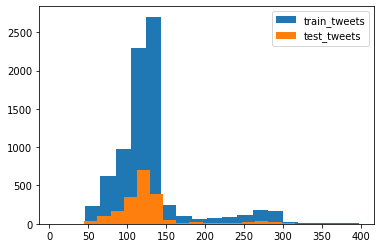

In [11]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.hist(length_train, bins=20,label='train_tweets')
plt.hist(length_test,bins=20,label='test_tweets')
plt.legend()
plt.show()

**Data Cleaning**

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features. If we skip this step then there is a higher chance that you are working with noisy and inconsistent data. The objective of this step is to clean noise those are less relevant to find the sentiment of tweets such as punctuation, special characters, numbers, and terms which don’t carry much weightage in context to the text.
Before we begin cleaning, let’s first combine train and test datasets. Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [12]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],ignore_index=True)

In [13]:
data.shape

(9873, 4)

In [14]:
def clean_tweet(text):
    
    # lower-case all characters
    text=text.lower()
    
    # remove twitter handles
    text= re.sub(r'@\S+', '',text) 
    
    # remove urls
    text= re.sub(r'http\S+', '',text) 
    text= re.sub(r'pic.\S+', '',text)
      
    
      
    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)
    
 
    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()  
    
    return text

In [15]:
data['tidy_tweet'] =data['tweet'].apply(lambda x: clean_tweet(x)) 
data.head()

,id,label,source,tweet,tidy_tweet
0,1,0.0,train,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0.0,train,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally a transparant silicon case thanks to my uncle yay sony xperia s sonyexperias
2,3,0.0,train,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,we love this would you go talk makememories unplug relax iphone smartphone wifi connect
3,4,0.0,train,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,i'm wired i know i'm george i was made that way iphone cute daventry home
4,5,1.0,train,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple won't even talk to me about a question i have unless i pay them for their stupid support


In [16]:
# removing short words
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split()
                                            if len(w)>3]))
data.head()

,id,label,source,tweet,tidy_tweet
0,1,0.0,train,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone
1,2,0.0,train,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,finally transparant silicon case thanks uncle sony xperia sonyexperias
2,3,0.0,train,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love this would talk makememories unplug relax iphone smartphone wifi connect
3,4,0.0,train,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,wired know george made that iphone cute daventry home
4,5,1.0,train,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amazing service apple won't even talk about question have unless them their stupid support


In [17]:
#text normalization
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0       [fingerprint, pregnancy, test, android, apps, beautiful, cute, health, igers, iphoneonly, iphonesia, iphone]
1                                   [finally, transparant, silicon, case, thanks, uncle, sony, xperia, sonyexperias]
2                          [love, this, would, talk, makememories, unplug, relax, iphone, smartphone, wifi, connect]
3                                                    [wired, know, george, made, that, iphone, cute, daventry, home]
4    [what, amazing, service, apple, won't, even, talk, about, question, have, unless, them, their, stupid, support]
Name: tidy_tweet, dtype: object

In [18]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

#stemming
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i)for i in x])

In [19]:
for i in range (len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

data['tidy_tweet'] = tokenized_tweet
data.head()

,id,label,source,tweet,tidy_tweet
0,1,0.0,train,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,fingerprint pregnanc test android app beauti cute health iger iphoneonli iphonesia iphon
1,2,0.0,train,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,final transpar silicon case thank uncl soni xperia sonyexperia
2,3,0.0,train,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,love thi would talk makememori unplug relax iphon smartphon wifi connect
3,4,0.0,train,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,wire know georg made that iphon cute daventri home
4,5,1.0,train,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,what amaz servic appl won't even talk about question have unless them their stupid support


**1. Understanding the common words used in the tweets: WordCloud**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization where in the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

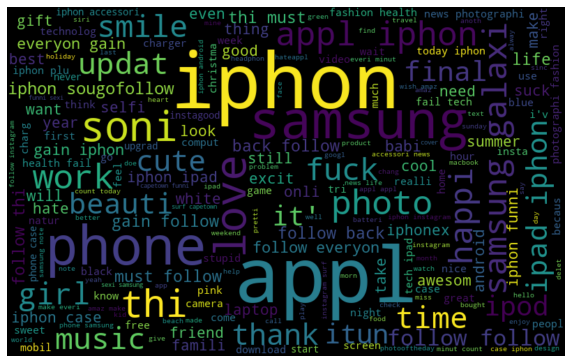

In [20]:
all_worlds = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state=21,
                     max_font_size=110).generate(all_worlds)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. Words like iphon, appl, phone are the most frequent ones. It doesn’t give us any idea about the words associated with the negative tweets. Hence, we will plot separate wordclouds for both the classes (negative or not) in our train data.

**non-negative tweeets:**

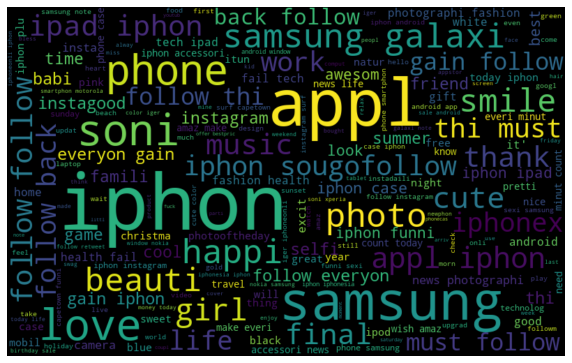

In [21]:
all_worlds = ' '.join([text for text in data['tidy_tweet'][data['label']==0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state=21,
                     max_font_size=110).generate(all_worlds)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

Most of the frequent words are compatible with the sentiment, i.e, positive tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative terms.

**Negative tweets**

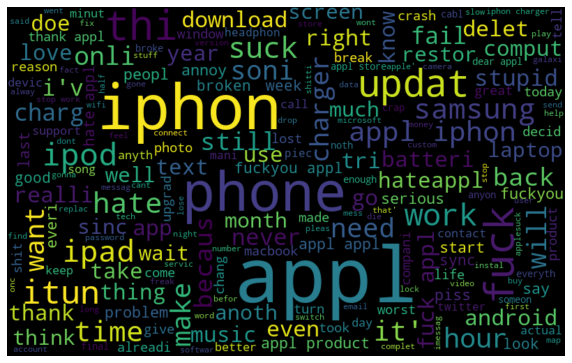

In [22]:
all_worlds = ' '.join([text for text in data['tidy_tweet'][data['label']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state=21,
                     max_font_size=110).generate(all_worlds)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on.

### Word2vec embeddings

In [23]:
import smart_open
smart_open.open = smart_open.smart_open
from gensim.models import Word2Vec

In [24]:
#tokenizing
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split())
model_w2v = Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

In [25]:
model_w2v.train(tokenized_tweet,
               total_examples=len(data['tidy_tweet']),
               epochs =20)

(1596475, 2084040)

**Preparing Vectors for Tweets**

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [26]:
def word_vector(tokens,size):
    vec = np.zeros(size).reshape((1,size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1,size))
            count +=1
        except KeyError:
            continue
    if count !=0:
        vec /= count
    return vec

In [27]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i],200)
    wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9873, 200)

### Modeling

In [28]:
train_w2v=wordvec_df.iloc[:7920,:]
test_w2v = wordvec_df.iloc[7920:,:]

In [29]:
from sklearn.model_selection import train_test_split
x_train_w2v, x_valid_w2v, y_train, y_valid = train_test_split(train_w2v,train['label'],random_state=42,test_size=0.3)

In [30]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth = 6, n_estimators=1000)
xgb.fit(x_train_w2v,y_train)
pred = xgb.predict_proba(x_valid_w2v)
pred_int = pred[:,1]>=0.3
pred_int = pred_int.astype(np.int)

In [31]:
from sklearn.metrics import f1_score

In [ ]:
f1_score = f1_score(y_valid,pred_int)
f1_score

In [32]:
test_pred = xgb.predict_proba(test_w2v)
test_pred_int = test_pred[:,1]>=0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission =test[['id','label']]
submission.to_csv('sub_xgb_w2v.csv',index=False)

AV Public leaderboard score: 0.8831

In [38]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(objective='binary',
                      boosting='gbdt',
                      learning_rate = 0.05,
                      max_depth = 8,
                      num_leaves = 80,
                      n_estimators = 400,
                      bagging_fraction = 0.8,
                      feature_fraction = 0.9)
lgb.fit(x_train_w2v,y_train)
pred = lgb.predict_proba(x_valid_w2v)
pred_int = pred[:,1]>=0.3
pred_int = pred_int.astype(np.int)

In [39]:
test_pred = lgb.predict_proba(test_w2v)
test_pred_int = test_pred[:,1]>=0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission =test[['id','label']]
submission.to_csv('sub_lgb_w2v.csv',index=False)

AV Public leaderboard score:0.8832